Extinction: B-K Binary
============================

In this example, we'll reproduce Figures 1 and 2 in the extinction release paper ([Jones et al. 2020](http://phoebe-project.org/publications/2020Jones+)).

> "Let us begin with a rather extreme case, a synthetic binary  comprised  of  a  hot,  B-type  main  sequence  star(M=6.5 Msol,Teff=17000  K,  and R=4.2 Rsol)  anda  cool  K-type  giant  (M=1.8 Msol,Teff=4000 K, and R=39.5 Rsol)vin a 1000 day orbit -- a  system  where, while the temperature difference is large, the luminosities are similar." ([Jones et al. 2020](http://phoebe-project.org/publications/2020Jones+))

<img src="jones+20_fig1.png" alt="Figure 1" width="800px"/>
<img src="jones+20_fig2.png" alt="Figure 2" width="400px"/>

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [ ]:
#!pip install -I "phoebe>=2.3,<2.4"

As always, let's do imports and initialize a logger and a new bundle. 

In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import gridspec

In [2]:
%matplotlib inline

In [3]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger('error')

b = phoebe.default_binary()

First we'll define the system parameters

In [4]:
b.set_value('period', component='binary', value=1000.0*u.d)
b.set_value('teff', component='primary', value=17000*u.K)
b.set_value('teff', component='secondary', value=4000*u.K)
b.set_value('requiv', component='primary', value=4.22173036*u.solRad)
b.set_value('requiv', component='secondary', value=40.732435*u.solRad)
b.flip_constraint('mass@primary', solve_for='sma@binary')
b.set_value('mass', component='primary', value=6.5*u.solMass)
b.flip_constraint('mass@secondary', solve_for='q')
b.set_value('mass', component='secondary', value=1.9145*u.solMass)

And then create three light curve datasets at the same times, but in different passbands

In [5]:
times = phoebe.linspace(-20, 20, 101)
b.add_dataset('lc', times=times, dataset='B', passband="Johnson:B")
b.add_dataset('lc', times=times, dataset='R', passband="Cousins:R")
b.add_dataset('lc', times=times, dataset='KEP', passband="Kepler:mean")

<ParameterSet: 42 parameters | contexts: figure, compute, dataset, constraint>

Now we'll set some atmosphere and limb-darkening options

In [6]:
b.set_value_all('atm', 'ck2004')
b.set_value_all('gravb_bol', 0.0)
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_func_bol', 'linear')
b.set_value_all('ld_coeffs_bol', [0.0])

And flip the extinction constraint so we can provide E(B-V).

In [7]:
b.flip_constraint('ebv', solve_for='Av')

<ConstraintParameter: {Av@system} = {Rv@system} * {Av@system} (solar units) => 0.0>

For comparison, we'll run a model without extinction

In [9]:
b.set_value('ebv', 0.0)
b.run_compute(distortion_method='rotstar', irrad_method='none', model='noext')

<ParameterSet: 7 parameters | datasets: KEP, B, R>

and then another model with extinction

In [10]:
b.set_value('ebv', 1.0)
b.run_compute(distortion_method='rotstar', irrad_method='none', model='ext')

<ParameterSet: 7 parameters | datasets: KEP, B, R>

Lastly, we'll convert the model fluxes into magnitudes and format the figures.

In [11]:
Bextmags=-2.5*np.log10(b['value@fluxes@B@ext@model'])
Bnoextmags=-2.5*np.log10(b['value@fluxes@B@noext@model'])
Bextmags_norm=Bextmags-Bextmags.min()+1
Bnoextmags_norm=Bnoextmags-Bnoextmags.min()+1
Bresid=Bextmags_norm-Bnoextmags_norm

Rextmags=-2.5*np.log10(b['value@fluxes@R@ext@model'])
Rnoextmags=-2.5*np.log10(b['value@fluxes@R@noext@model'])
Rextmags_norm=Rextmags-Rextmags.min()+1
Rnoextmags_norm=Rnoextmags-Rnoextmags.min()+1
Rresid=Rextmags_norm-Rnoextmags_norm

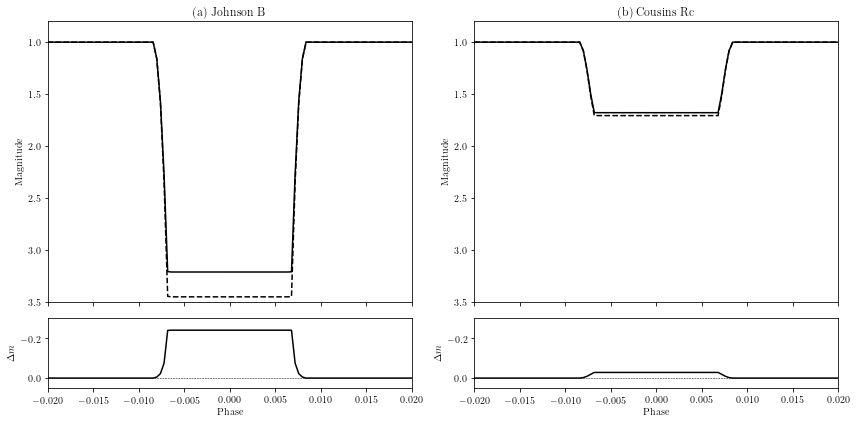

In [12]:
fig=plt.figure(figsize=(12,6))
gs=gridspec.GridSpec(2,2,height_ratios=[4,1],width_ratios=[1,1])

ax=plt.subplot(gs[0,0])
ax.plot(b['value@times@B@noext@model']/1000,Bnoextmags_norm,color='k',linestyle="--")
ax.plot(b['value@times@B@ext@model']/1000,Bextmags_norm,color='k',linestyle="-")
ax.set_ylabel('Magnitude')
ax.set_xticklabels([])
ax.set_xlim([-0.02,0.02])
ax.set_ylim([3.5,0.8])
ax.set_title('(a) Johnson B')

ax2=plt.subplot(gs[0,1])
ax2.plot(b['value@times@R@noext@model']/1000,Rnoextmags_norm,color='k',linestyle="--")
ax2.plot(b['value@times@R@ext@model']/1000,Rextmags_norm,color='k',linestyle="-")
ax2.set_ylabel('Magnitude')
ax2.set_xticklabels([])
ax2.set_xlim([-0.02,0.02])
ax2.set_ylim([3.5,0.8])
ax2.set_title('(b) Cousins Rc')

ax_1=plt.subplot(gs[1,0])
ax_1.plot(b['value@times@B@noext@model']/1000,Bresid,color='k',linestyle='-')
ax_1.set_ylabel(r'$\Delta m$')
ax_1.set_xlabel('Phase')
ax_1.set_xlim([-0.02,0.02])
ax_1.set_ylim([0.05,-0.3])
ax_1.axhline(y=0., linestyle='dashed',color='k',linewidth=0.5)


ax2_1=plt.subplot(gs[1,1])
ax2_1.plot(b['value@times@R@noext@model']/1000,Rresid,color='k',linestyle='-')
ax2_1.set_ylabel(r'$\Delta m$')
ax2_1.set_xlabel('Phase')
ax2_1.set_xlim([-0.02,0.02])
ax2_1.set_ylim([0.05,-0.3])
ax2_1.axhline(y=0., linestyle='dashed',color='k',linewidth=0.5)

plt.tight_layout()
fig.canvas.draw()

In [13]:
KEPextmags=-2.5*np.log10(b['value@fluxes@KEP@ext@model'])
KEPnoextmags=-2.5*np.log10(b['value@fluxes@KEP@noext@model'])
KEPextmags_norm=KEPextmags-KEPextmags.min()+1
KEPnoextmags_norm=KEPnoextmags-KEPnoextmags.min()+1
KEPresid=KEPextmags_norm-KEPnoextmags_norm

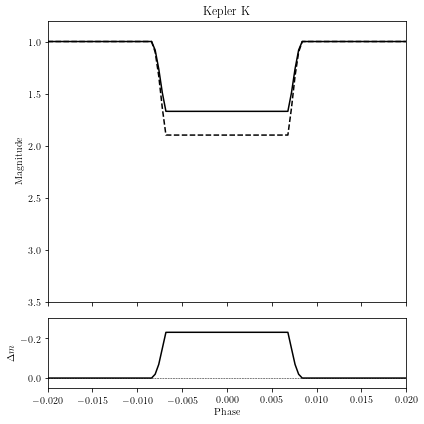

In [14]:
fig=plt.figure(figsize=(6,6))
gs=gridspec.GridSpec(2,1,height_ratios=[4,1])

ax=plt.subplot(gs[0])
ax.plot(b['value@times@KEP@noext@model']/1000,KEPnoextmags_norm,color='k',linestyle="--")
ax.plot(b['value@times@KEP@ext@model']/1000,KEPextmags_norm,color='k',linestyle="-")
ax.set_ylabel('Magnitude')
ax.set_xticklabels([])
ax.set_xlim([-0.02,0.02])
ax.set_ylim([3.5,0.8])
ax.set_title('Kepler K')

ax_1=plt.subplot(gs[1])
ax_1.plot(b['value@times@KEP@noext@model']/1000,KEPresid,color='k',linestyle='-')
ax_1.set_ylabel(r'$\Delta m$')
ax_1.set_xlabel('Phase')
ax_1.set_xlim([-0.02,0.02])
ax_1.set_ylim([0.05,-0.3])
ax_1.axhline(y=0., linestyle='dashed',color='k',linewidth=0.5)

plt.tight_layout()
fig.canvas.draw()